# **Laboratory 3 (optional) - State Feedback Controller design for Cart-pole**
In this laboratory session, you will use linear control theory concepts and get your hands on a concrete example: the cart-pole.
More especially, you will design a controller for the cart-pole such that it is robust to a disturbance modeled as a push on the cart.

## **Instructions**

**Deliverable.**
You should answer the questions of this lab in a short `.pdf` report.

**Grading.**
This laboratory is optional but will be graded if you choose to submit it.
It will be taken into account in the final grade of the course if it increases your final grade.

**Deadline.**
The submission deadline is on the **16th of May 2025 at 11:59PM**.

**Submission.**
Submit your report on [Gradescope](https://www.gradescope.com/) by logging in with your account `@student.uliege.be`. Don't forget to assign the corresponding pages to the different questions when submitting.
If the course does not appear in your dashboard on Gradescope, contact us on [Ed Discussion](https://edstem.org/us/dashboard) quickly. If you are not familiar with submitting your work to Gradescope, you will find all the necessary information in the [online help](https://help.gradescope.com/article/ccbpppziu9-student-submit-work).

**Collaboration policy.**
You can discuss the assignment with other students, but *you must write your own solutions, and write and run your own code*. Copying someone else's solution, or just making trivial changes to avoid copying verbatim, is not acceptable.


**You may just `Run All` and then you can start.**

In [3]:
# @title
from ipywidgets import *
from IPython.display import display
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# import logging
plt.close("all")

COLAB=False
try :
    %matplotlib widget
except:
    mpl.use('nbagg')
    COLAB=True

mpl.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['axes.titlepad'] = 15
plt.rcParams['axes.titlesize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.labelweight'] = 'bold'

try :
    import control
except:
    print("/!\ python-control package is not installed" )
    !pip install control
    import control

gravity = 9.81
mass_cart = 1.0
mass_pole = 0.1
length = 0.5
def cartpole_update(t, x, u, params):
    g = 9.81  # gravity
    mc = 1.0  # mass of the cart
    mp = 0.1  # mass of the pole
    l = 0.5   # length of the pole

    # states
    _, x_dot, theta, theta_dot = x
    F = u[0] + u[1]

    # equations of motion
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    divisor = mc + mp*sin_theta**2

    x_ddot = (F + mp*sin_theta*(l*theta_dot**2 + g*cos_theta))/(divisor)
    theta_ddot = (-F*cos_theta -mp*l*theta**2 * sin_theta*cos_theta - (mc+mp)*g*sin_theta)/(l*divisor)

    return [x_dot, x_ddot, theta_dot, theta_ddot]

def cartpole_output(t, x, u, params):
    return x[2] + u[-1]

SYSTEM = control.nlsys(cartpole_update, cartpole_output, inputs=('u', 'v', 'w'), outputs=(r'$\theta$'),
                         states=('x', 'x_dot', r'$\theta$', 'theta_dot'), name='cartpole')
TF_LIN_SYSTEM = control.tf([1], [length*mass_cart, 0, -gravity*(mass_pole+mass_cart)])

A_LIN = np.array([[0, 0, 1, 0],
         [0, 0, 0, 1],
         [0, gravity*mass_pole/mass_cart, 0, 0],
         [0, gravity*(mass_pole+mass_cart)/(length*mass_cart), 0, 0]])

B_LIN = np.array([[0], [0], [1/mass_cart], [1/(length*mass_cart)]])

def disturbance(time):
    signal = np.where(time < 0.25, 100.0*np.sin(4*np.pi*time), np.zeros_like(time))
    return signal

class OutPlot:
    def __init__(self, **kwargs):
        self.output = Output()
        self._init_plot(**kwargs)

    def __call__(self, *args, **kwds):
        self.output.clear_output(wait=True)
        with self.output:
            self._plot(*args, **kwds)

    def _plot(self, *args, **kwds):
        pass

    def _init_plot(self, *args, **kwds):
        pass

class ResponsePlot(OutPlot):
    def _init_plot(self, fig_name="all", title=None, tau=5e-2, seed=42):

        np.random.seed(seed)
        self.output.layout.height = '100%'
        self.output.layout.width = '50%'
        plt.close(fig_name)
        self.figure = plt.figure(fig_name, figsize=(12,5),
                                 dpi=100, clear=True)
        self.figure.canvas.header_visible = False
        self.ax = self.figure.add_subplot(1,1,1)
        self.ax.set_xlabel("Time [s]")
        self.ax.set_ylabel("Amplitude [rad]")
        self.ax.set_title(title)

        self.final_T = 15
        self.ax.hlines(np.pi, 0, self.final_T, color='r', linestyle='--', zorder=10)
        self.lines, = self.ax.plot([], [], color='blue')
        self.ax.legend(['Reference', '$\Theta$'])
        self.lowpass = control.zpk([], [-1/tau]*3, (-1/tau)**3, dt=0)
        self.highpass = 1 - self.lowpass

        self.time = np.linspace(0, self.final_T, 5000)
        white_noise = control.white_noise(self.time, np.array([[1e-4, 0], [0, 0.1]]))
        self.disturbance = control.forced_response(self.lowpass, T=self.time, U=white_noise[1])
        self.noise = control.forced_response(self.highpass, T=self.time, U=white_noise[0])

        self.parameters = dict(kp=1, ki=0, kd=0, noise=False, disturbance=False, deviation=np.pi/12)

    def _on_change(self, **kwargs):
        self.parameters.update(kwargs)

    def _on_click(self, button):
        self(**self.parameters)

    def _plot(self, kp, ki, kd,
              noise=False, disturbance=False,
              deviation=2*np.pi/12):
        t = self.time
        pi_controller = control.tf([kp], [1]) + control.tf([ki], [1, 0]) + control.tf([kd*1, 0], [1e-3, 1])
        pi_controller.update_names(name='pi_controller')
        open_loop = control.interconnect([SYSTEM, pi_controller],
                                         connections=[['cartpole.u', 'pi_controller.y'],],
                                         inplist=['pi_controller.u', 'cartpole.v', 'cartpole.w'],
                                         outlist=[r'cartpole.$\theta$'],
                                         name='open_loop')

        sum_junc = control.summing_junction(2, 1, name='sum_junc')
        cartpole_pi = control.interconnect([open_loop, sum_junc],
                                           connections=[['sum_junc.u[1]', '-open_loop.y[0]'],
                                                        ['open_loop.u[0]','sum_junc.y[0]']],
                                           inplist=['sum_junc.u[0]', 'open_loop.u[1]', 'open_loop.u[2]'],
                                            outlist=['open_loop.y[0]'],
                                            name='closed_loop')

        inputs = np.zeros((3, len(t)))
        inputs[0]+=np.pi
        if noise:
            inputs[2] = 1.0 * self.noise.y
        if disturbance:
            inputs[1] = 1.0 * self.disturbance.y

        print("Computing ...", end='\r')
        states = control.input_output_response(cartpole_pi, U=inputs,
                                       X0=[0,0,np.pi - deviation,0], T=t, squeeze=True)

        # Transform the dictionary into printable key-value pairs
        step_info = control.step_info(states.outputs, T=t)
        print(*[f"{key}: {value:.05f}" for key, value in step_info.items()], sep='\n')
        self.lines.remove()
        self.lines, = self.ax.plot(t, states.states[2], color='blue')
        min_ax, max_ax = min(min(states.y[0]), np.pi), max(max(states.y[0]), np.pi)
        self.ax.set_ylim([min_ax - 0.1, max_ax + 0.1])
        display(self.figure)

class FullPlot(OutPlot):
    def _init_plot(self, fig_name="all", title=None):
        self.output.layout.height = '100%'
        self.output.layout.width = '100%'

        plt.close(fig_name)
        self.figure = plt.figure(fig_name, figsize=(12, 10), dpi=100)
        self.axes = self.figure.subplots(2, 2)
        self.figure.subplots_adjust(hspace=0.5)
        self.parameters = dict(k=1, zlead=0, plead=0)
        self.plant = TF_LIN_SYSTEM.copy()
        self.plant.update_names(name='plant')
        self.time = np.linspace(0, 15, 5000)

    def _on_change(self, **kwargs):
        self.parameters.update(kwargs)

    def _on_click(self, button):
        self(**self.parameters)

    def _plot(self, k, zlead, plead):
        t = self.time
        controller = k * control.tf([1, -zlead], [1, -plead])
        controller.update_names(name='control')
        open_loop = controller * self.plant
        open_loop.update_names(name='open_loop')

        sum_junc = control.summing_junction(2, 1, name='sum_jct')
        closed_loop = control.interconnect([controller, self.plant, sum_junc],
                                            [['control.u[0]', '-plant.y[0]'],
                                            ['plant.u[0]', 'sum_jct.y[0]'],
                                            ['sum_jct.u[0]', 'control.y[0]']],
                                            inplist=['sum_jct.u[1]'],
                                            outlist=['plant.y'], name='closed_loop', debug=False)

        inputs = disturbance(t)
        print("Computing ...", end='\r')
        for ax in self.axes.flatten():
            ax.clear()

        #Bode plots of the system
        control.bode_plot(open_loop, display_margins='overlay', dB=True, ax=self.axes[:,0])
        self.axes[0, 0].set_title('Bode plots')

        # Nyquist plot of the system
        plt.figure(self.figure.number)
        plt.sca(self.axes[0, 1])
        control.nyquist_plot(open_loop, unit_circle=True, ax=self.axes[0, 1])
        self.axes[0, 1].set_title('Nyquist plot')

        # Step response of the system
        states = control.input_output_response(closed_loop, U=inputs, T=t, squeeze=True)
        self.axes[1, 1].plot(t, states.y[0])
        self.axes[1, 1].set(title='Time response to $d(t)$', xlabel='Time [s]', ylabel='Angle deviation [rad]')
        print('')
        display(self.figure)

class RespPlot(OutPlot):
    def _init_plot(self, fig_name="all", title=None):
        self.output.layout.height = '100%'
        self.output.layout.width = '100%'

        plt.close(fig_name)
        self.figure = plt.figure(fig_name, figsize=(12, 5), dpi=100)
        self.ax = self.figure.add_subplot(1,1,1)
        self.ax.set_xlabel("Time [s]")
        self.ax.set_ylabel("Angle deviation [rad]")
        self.ax.set_title(title)

        self.parameters = dict(k_1=1, k_2=1, k_3=1, k_4=1)
        self.A = A_LIN.copy()
        self.B = B_LIN.copy()

        self.time = np.linspace(0, 15, 1000)

    def _on_change(self, **kwargs):
        self.parameters.update(kwargs)

    def _on_click(self, button):
        self(**self.parameters)

    def _plot(self, k_1, k_2, k_3, k_4):
        k = np.array([[k_1, k_2, k_3, k_4]])
        system = control.ss(self.A - self.B@k, self.B, np.eye(4), np.zeros((4, 1)), dt=0)
        system.update_names(name='system')
        t = self.time
        plt.figure(self.figure.number)
        inputs = disturbance(t)
        print("Computing ...", end='\r')
        self.ax.clear()
        # Step response of the system
        states = control.input_output_response(system, U=inputs, T=t, squeeze=True)
        self.ax.plot(t, states.y[1], label="Response")
        self.ax.axhline(0, 0, 15, color='r', linestyle='--', label="Reference (0)")
        self.ax.legend()
        # self.ax.hlines(0.0, 0, self.final_T, color='r', linestyle='--', label="Reference (0)")
        self.ax.set(title='Time response to $d(t)$', xlabel='Time [s]', ylabel='Angle deviation [rad]')
        print('')
        display(self.figure)

def create_buttons():
    param_list=[]
    for i in range(4):
       param_list.append(BoundedFloatText(value=1, min=-5e3, max=5e3, step=.1, description='k_'+str(i+1)))
    param_list.append(Button(description='Run simulation'))
    box = VBox(param_list, layout=Layout(flex_flow='column', align_items='center'))
    return box, param_list



<>:29: SyntaxWarning: invalid escape sequence '\ '
<>:109: SyntaxWarning: invalid escape sequence '\T'
<>:29: SyntaxWarning: invalid escape sequence '\ '
<>:109: SyntaxWarning: invalid escape sequence '\T'
C:\Users\tbeau\AppData\Local\Temp\ipykernel_22584\2584414573.py:29: SyntaxWarning: invalid escape sequence '\ '
  print("/!\ python-control package is not installed" )
C:\Users\tbeau\AppData\Local\Temp\ipykernel_22584\2584414573.py:109: SyntaxWarning: invalid escape sequence '\T'
  self.ax.legend(['Reference', '$\Theta$'])


## **Model**

### **Cart-Pole**
Before designing our controller, we need a model for the cart-pole. We will focus on the angle of the pole $\theta$.
The system being non-linear, we will linearize it around the equilibrium point $\theta = \pi$.
The parameters are the length of the pole $l$, the mass of the cart $m_c$, the mass of the pole $m_p$, and the gravity constant $g$.
The input is the force $f_x$ applied to the cart, and the output is the deviation $\tilde \theta$ of the angle around the equilibrium point $\theta = \pi$ of the pole.

The state-space model of the linearized system is given by

$$
\begin{pmatrix}
    \dot x \\
    \dot{\tilde \theta} \\
    \ddot x \\
    \ddot{\tilde \theta}
\end{pmatrix} = \begin{bmatrix}0 & 0 & 1 & 0\\ 0 & 0 & 0 & 1\\ 0 & \frac{g m_{p}}{m_{c}} & 0 & 0\\ 0 & \frac{g (m_{c} + m_{p})}{l m_{c}} & 0 & 0\end{bmatrix}\begin{pmatrix}
    x \\
    {\tilde \theta} \\
    \dot x \\
    \dot{\tilde \theta}
\end{pmatrix}+\begin{bmatrix}0\\ 0\\ \frac{1}{m_{c}}\\ \frac{1}{l m_{c}}\end{bmatrix} f_x(t)
$$
$$
y(t) = \begin{bmatrix}0 & 1 & 0 & 0\end{bmatrix} \begin{pmatrix}
    x \\
    {\tilde \theta} \\
    \dot x \\
    \dot{\tilde \theta}
\end{pmatrix}
$$

where $l = 0.5$ m, $m_c = 1$ kg, $m_p = 0.1$ kg, and $g = 9.81$ m/s $^2$.

### **Controller**
The force actuator of the cart will be controlled by a state-feedback controller, so that the control $f_x(t)$ writes
$$f_x(t) = - \begin{bmatrix} k_1 & k_2 & k_3 & k_4 \end{bmatrix} \begin{bmatrix} x \\ \tilde \theta \\ \dot{x} \\ \dot{\tilde \theta} \end{bmatrix}.$$

As we did in the previous laboratory, we will simulate the cart-pole with a push on the cart modeled as

\begin{equation*}
d(t) =
  \begin{cases}
    100\sin(\omega^\star t) & \text{if} \quad t\in[0, 0.25],\\
    0.0 & \text{otherwise.}
  \end{cases}
\end{equation*}
$\omega^\star = 4\pi \text{ rad/s}.$

## **Theoretical questions**
Before getting your hands on simulations, answer the following questions:

> ❓**Q1.**
>
> **a)** Compute the observability matrix.
>
> **b)** Assess the observability of the system.
>
> ❓**Q2.**
>
> **a)** Compute the controllability matrix.
>
> **b)** Assess the controllability of the system.
>
> ❓**Q3.** Could you design a Luenberger observer for the system? If not, what could you change in the system to make it possible?
>


## **State feedback controller design**

As stated above, the control input $f_x(t)$ is given by
$$
    f_x(t) = -k_1 x - k_2 \tilde \theta - k_3 \dot x - k_4 \dot{\tilde \theta}
$$

In order to have stable closed-loop system, you will place the 4 poles of the closed-loop transfer function $G_{yr}$ at -10 , you will have to use the characteristic polynomial defined by
$det(sI - (A - BK))$.

To avoid long computations, here is this polynomial:
$$
det(sI - (A - BK)) = s^4 + \frac{k_{3} l + k_{4}}{l m_{c}} s^3 + \frac{- g m_{c} - g m_{p} + k_{1} l + k_{2}}{l m_{c}} s^2
- \frac{g k_{3}}{l m_{c}} s - \frac{g k_{1}}{l m_{c}}
$$

> ❓**Q4.** What are the gains $k_1, k_2, k_3, k_4$ that satisfy the requirements ?.

> ❓**Q5.** Based on the simulation below and in a few words, explain whether the controller is satisfying.
>
The cell below computes the response of the closed-loop system to the disturbance $d(t)$.

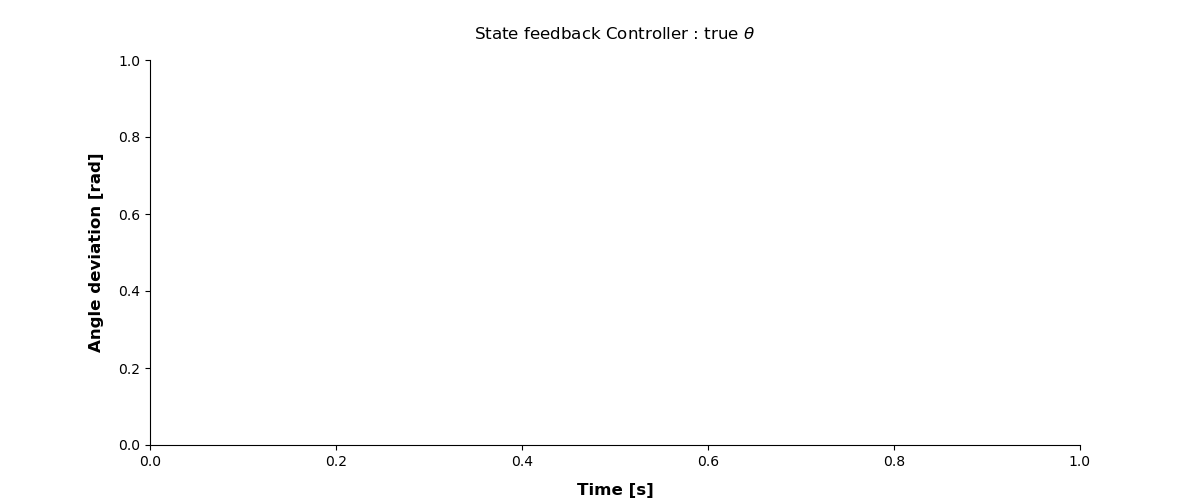

In [4]:
# @title
response_plot_pid = RespPlot(
    fig_name="cartpole_ssfb", title=r"State feedback Controller : true $\theta$")
vbox_pid, ss_params = create_buttons()
button_pid = ss_params[-1]
button_pid.on_click(response_plot_pid._on_click)
k_1, k_2, k_3, k_4 = ss_params[:4]

box_pid = HBox([response_plot_pid.output, vbox_pid], layout=Layout(
    width='100%', align_items='center')) if COLAB else vbox_pid
out_pid = interactive_output(response_plot_pid._on_change, {
                             'k_1': k_1, 'k_2': k_2, 'k_3': k_3, 'k_4': k_4})
display(box_pid)